In [2]:
import os 
print(os.getcwd())

c:\Users\chenh\OneDrive\Desktop\simulations\paper1\sim\bundle1_2


In [3]:
import numpy as np
import pandas as pd
from scipy import optimize
from scipy.special import erf
from scipy.stats import norm, gamma, ttest_ind, wilcoxon
import math
import warnings
import matplotlib.pyplot as plt
from scipy.special import erf
warnings.simplefilter(action='ignore')
np.set_printoptions(suppress=True, formatter={'float_kind':'{:0.5f}'.format})
# np.set_printoptions(suppress=True, formatter={'float_kind':'{:0.5f}'.format})
from MaxLikelihood_1g_May_2021 import LK_MLE
# from MaxLikelihood_1g_May_2021_exp import LK_MLE_EXP    

In [4]:
#w = 104; w1 = 52
w = 52
# generate spend from a normal distribution with mean 1000 and std 100
# set seed for reproducibility
np.random.seed(2024)
# spend1 = np.random.normal(1000, 100, w1)
# spend2 = np.random.normal(1000, 100, 20)*1.4
# spend3 = np.random.normal(1000, 100, w - w1 - 20)
# combine the above into one names as speed
# spend = np.concatenate([spend1, spend2, spend3])
np.random.seed(2024)
spend = np.random.normal(1000, 100, w)
L = 5


In [5]:
# the spend_st is the observed spend
seasonality = 100 * np.sin(2 * math.pi * np.arange(w) / 52) 
#
trend = 1*np.arange(w)
#
# combine spend, seasonality and trend by row to form a pd dataframe
#df = pd.DataFrame({'spend': spend, 'seasonality': seasonality, 'trend': trend})

In [5]:
# plt.figure(figsize=(12, 6))
# plt.plot(df['spend'], label='spend')
# plt.plot(df['seasonality'], label='seasonality')
# # plt.plot(df['trend'], label='trend')
# plt.legend()
# plt.show()

In [6]:
##### get the diag chunk
def power_chen(alpha, k):
    seq_l = np.linspace(k, 0, k+1)
    tem = alpha**seq_l
    return tem

In [7]:
n = len(spend)
#L = 13
spend_s = np.zeros(n)
for i in range(len(spend)):
    if i < L:
        # subset the first i spend
        spend_sub = spend[:i+1]
        #power_chen(alpha = 0.5, i) * spend_sub
        spend_s[i] = np.sum(power_chen(alpha = 0.6, k = i) * spend_sub)
    else:
        spend_sub = spend[i-L:i+1]
        spend_s[i] = np.sum(power_chen(alpha = 0.6, k = L) * spend_sub)

In [8]:
# # plot spend and spend_s
# plt.figure(figsize=(12, 6))
# plt.plot(spend, label='spend')
# plt.plot(spend_s, label='spend_s')
# plt.legend()
# plt.show()

In [9]:
# let's do a scaling on spend_s
spend_s1 = spend_s/1000
#
# now let's do a Hill function on spend_s
spend_trans = 1/(1 + (spend_s1/1)**(-2))
# scale back
spend_trans = spend_trans*1000

# now we can compute y 
np.set_printoptions(suppress=True, formatter={'float_kind':'{:0.5f}'.format})
# generate z from a uniform distribution
np.random.seed(2025)
z1 = np.random.uniform(100, 200, w)
np.random.seed(2029)
z2 = np.random.uniform(20, 80, w)
# set seed
np.random.seed(2025)
y = 1 + 1.5*spend_trans + 0.1*seasonality + 0.2*trend + 1*z1 + 1*z2 + np.random.normal(0, 5, w)
# now let's compute the true ROI and the true lift
# the total spend in that 20 weeks
#total_spend = spend[w1:w1+20].sum()
total_spend = spend.sum()
# total reward in that 20 weeks
# compute y_bar without spend
y_bar = 1 + 0.1*seasonality + 0.2*trend + 1*z1 + 1*z2
# compute the difference in that 20 weeks
# diff = (y[w1:w1+20+L] - y_bar[w1:w1+20+L]).sum()
diff = (y - y_bar).sum()
#
roi = (diff - total_spend)/total_spend
print('The true ROI is', roi)

The true ROI is 0.2615035614691359


In [10]:
# let's combine spend, seasonality, trend, z and y into a pd dataframe
df = pd.DataFrame({'spend': spend, 'seasonality': seasonality, 'trend': trend, 'z1': z1, 'z2':z2, 'y': y})
# add one more column to the beginning of the dataframe named as cluster and all elements are 1
df.insert(0, 'cluster', 1)
# add one more column next to cluster named as store and all elements are 1
df.insert(1, 'store', 1)
# add one more column next to store named as product and all elements are 1
df.insert(2, 'product', 1)
df.head(5)

,cluster,store,product,spend,seasonality,trend,z1,z2,y
0,1,1,1,1166.804732,0.000000,0,113.548816,28.265670,1007.145092
1,1,1,1,1073.734773,12.053668,1,188.785170,35.840356,1368.945245
2,1,1,1,979.846224,23.931566,2,193.260564,73.126862,1473.326737
3,1,1,1,984.908805,35.460489,3,144.556816,57.412264,1449.139882
4,1,1,1,1091.605181,46.472317,4,138.823555,47.003767,1472.756062


In [11]:
# now let's do the MLE estimation
m = 1
nn = 4
g = 1
############ Fit MLE
############## Fit MLE 
######### get the bounds
mybounds = [(0,1), # alpha
            (0,2), # lambda
            (0,2), # beta0 
            (0,2), # beta1 
            (0,10), (0, 10), (0, 10), (0, 10), 
            (0, 50)] 
##########
K = 200
t_bfgs = np.inf; t_sqp = np.inf
op_s = np.tile(0, len(mybounds))
op_sqp = np.tile(0, len(mybounds))

for k in range(K):
    np.random.seed(2020+2*k)
    alpha_s = np.random.uniform(size = m)
    # np.random.seed(2020+2*k)
    # k_s = np.random.uniform(size = m)
    np.random.seed(2020+2*k)
    lambda_s = np.random.uniform(size = m)
    np.random.seed(2020+2*k)
    intercepts = np.random.uniform(low =0.5, high = 1.5, size = g)
    np.random.seed(2020+2*k)
    beta = np.random.uniform(low = 0.01, high = 2.5, size = (m+nn))
    np.random.seed(2020+2*k)
    v0 = np.random.uniform(low = 10, high = 50, size = 1)
    ######### combine
    phi0 = np.concatenate((alpha_s, lambda_s, intercepts, beta, v0))
    ######### get the object 
    tem = LK_MLE(Y = df, m = m, n = nn, l = 5, year = int(w/52), response = 'Hill_S')
    ######## BFGS 
    np.random.seed(2020+2*k)
    fit1 = optimize.minimize(tem._negative_log_posterior, x0=phi0, method = 'L-BFGS-B', 
                             bounds=mybounds,
                            options={'gtol': 1e-08, 'eps': 1e-08})
    if fit1.fun < t_bfgs:
        t_bfgs = fit1.fun
        op_s = fit1.x
    
    ######## SQP 
    np.random.seed(2021+2*k)
    fit2 = optimize.minimize(tem._negative_log_posterior, x0=phi0, method = 'SLSQP', 
                             bounds=mybounds,
                            options={'ftol': 1e-08, 'eps': 1e-08}) 
    if fit2.fun < t_sqp:
        t_sqp = fit2.fun
        op_sqp = fit2.x

####### get the results     
res_bfgs = op_s
res_sqp = op_sqp

In [12]:
res_bfgs

array([0.10811, 0.00000, 0.57362, 1.47208, 0.00000, 0.00000, 0.00000,
       0.00000, 50.00000])

In [13]:
res_sqp

array([0.38292, 0.78426, 1.34500, 1.50907, 0.74398, 2.46272, 0.93511,
       0.95145, 45.86479])

In [14]:
# Now let's use the number to compute the ROI
alpha_s = res_sqp[0]
lambda_s = res_sqp[1]
intercepts = res_sqp[2]
beta = res_sqp[3]
theta = res_sqp[4:4+nn]

# 
spend = df['spend'].values
#compute the predicted y 
n = len(spend)
#L = 13
spend_s = np.zeros(n)
for i in range(len(spend)):
    if i < L:
        # subset the first i spend
        spend_sub = spend[:i+1]
        #power_chen(alpha = 0.5, i) * spend_sub
        spend_s[i] = np.sum(power_chen(alpha = alpha_s, k = i) * spend_sub)
    else:
        spend_sub = spend[i-L:i+1]
        spend_s[i] = np.sum(power_chen(alpha = alpha_s, k = L) * spend_sub)

# 
# let's do a scaling on spend_s
spend_s1 = spend_s/1000
#
# now let's do a Hill function on spend_s
spend_trans = 1/(1 + (spend_s1/lambda_s)**(-2))
# scale back
spend_trans = spend_trans*1000

# now we can compute y 
# generate z from a uniform distribution
# set seed
y = intercepts + beta*spend_trans + theta[0]*df['seasonality'].values + theta[1]*df['trend'].values + theta[2]*df['z1'].values + theta[3]*df['z2'].values
# now let's compute the true ROI and the true lift
# the total spend in that 20 weeks
#total_spend = spend[w1:w1+20].sum()
total_spend = spend.sum()
# total reward in that 20 weeks
# compute y_bar without spend
y_bar = intercepts + theta[0]*df['seasonality'].values + theta[1]*df['trend'].values + theta[2]*df['z1'].values + theta[3]*df['z2'].values
# compute the difference in that 20 weeks
# diff = (y[w1:w1+20+L] - y_bar[w1:w1+20+L]).sum()
diff = (y - y_bar).sum()
#
roi = (diff - total_spend)/total_spend
print('The estimated ROI is', roi)

The estimated ROI is 0.21336437100912364


In [15]:
#raise SystemExit('Stop right there!')

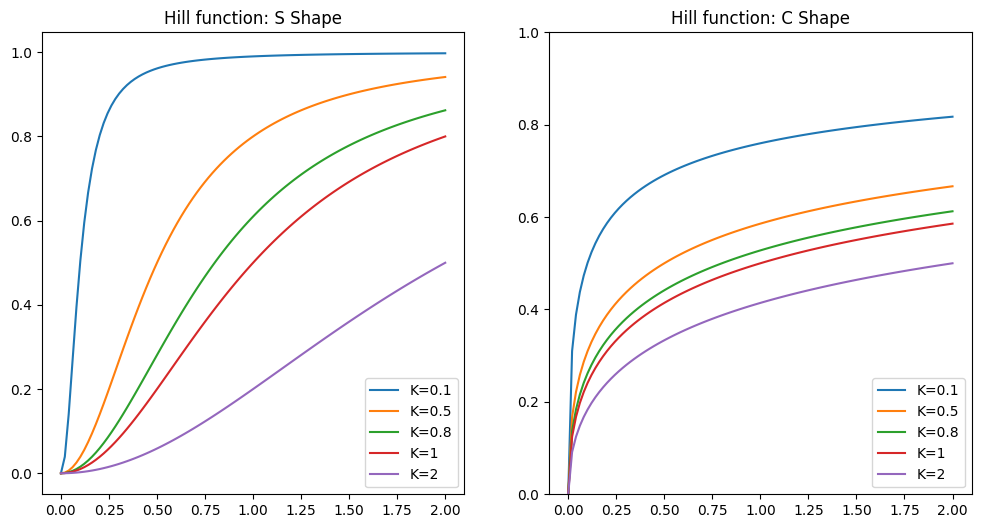

In [8]:
# simulate x from 0 to 2 
x = np.linspace(0, 2, 100)
y1 = 1/(1 + (x/0.1)**(-2))
y2 = 1/(1 + (x/0.5)**(-2))
y3 = 1/(1 + (x/0.8)**(-2))
y4 = 1/(1 + (x/1)**(-2))
y5 = 1/(1 + (x/2)**(-2))
#
y1_c = 1/(1 + (x/0.1)**(-0.5))
y2_c = 1/(1 + (x/0.5)**(-0.5))
y3_c = 1/(1 + (x/0.8)**(-0.5))
y4_c = 1/(1 + (x/1)**(-0.5))
y5_c = 1/(1 + (x/2)**(-0.5))
# create a figure with 2 by 1 panels
fig, axs = plt.subplots(1, 2, figsize=(12, 6))



# plot the left panel
axs[0].plot(x, y1, label='K=0.1')
axs[0].plot(x, y2, label='K=0.5')
axs[0].plot(x, y3, label='K=0.8')
axs[0].plot(x, y4, label='K=1')
axs[0].plot(x, y5, label='K=2')
axs[0].set_title('Hill function: S Shape')
# always put legend to the right corner
axs[0].legend(loc='lower right')
#axs[0].legend()

# plot the right panel
axs[1].plot(x, y1_c, label='K=0.1')
axs[1].plot(x, y2_c, label='K=0.5')
axs[1].plot(x, y3_c, label='K=0.8')
axs[1].plot(x, y4_c, label='K=1')
axs[1].plot(x, y5_c, label='K=2')
axs[1].set_title('Hill function: C Shape')
axs[1].legend(loc='lower right')
# y limit is from 0 to 1
plt.ylim(0, 1)

plt.show()


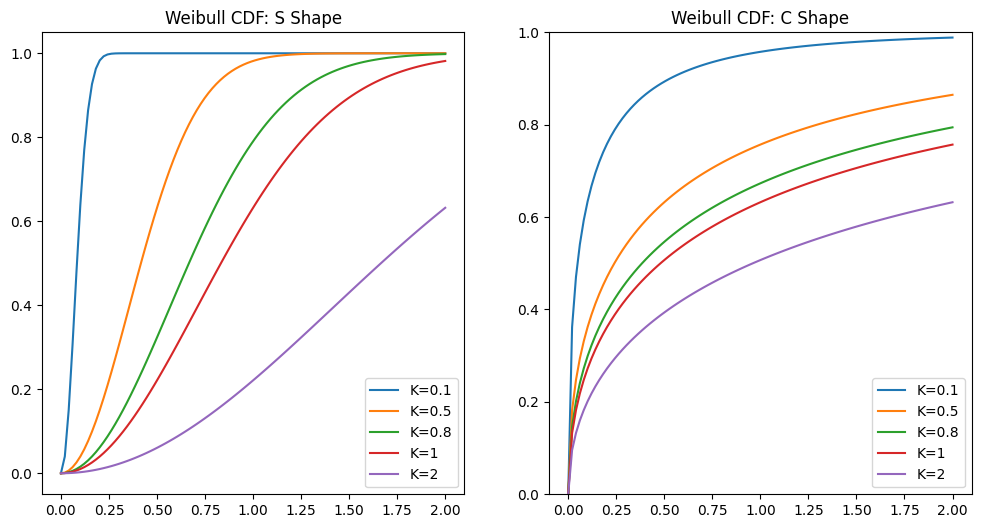

In [9]:
# simulate x from 0 to 2 
# Weibull CDF 
def weibull_cdf(x, lam, k):
    return 1 - np.exp(-(x/lam)**k)

x = np.linspace(0, 2, 100)
K = 2
y1 = weibull_cdf(x, lam = 0.1, k = K)
y2 = weibull_cdf(x, lam = 0.5, k = K)
y3 = weibull_cdf(x, lam = 0.8, k = K)
y4 = weibull_cdf(x, lam = 1, k = K)
y5 = weibull_cdf(x, lam = 2, k = K)
#
K = 0.5
y1_c = weibull_cdf(x, lam = 0.1, k = K)
y2_c = weibull_cdf(x, lam = 0.5, k = K)
y3_c = weibull_cdf(x, lam = 0.8, k = K)
y4_c = weibull_cdf(x, lam = 1, k = K)
y5_c = weibull_cdf(x, lam = 2, k = K)
# create a figure with 2 by 1 panels
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# plot the left panel
axs[0].plot(x, y1, label='K=0.1')
axs[0].plot(x, y2, label='K=0.5')
axs[0].plot(x, y3, label='K=0.8')
axs[0].plot(x, y4, label='K=1')
axs[0].plot(x, y5, label='K=2')
axs[0].set_title('Weibull CDF: S Shape')
axs[0].legend()

# plot the right panel
axs[1].plot(x, y1_c, label='K=0.1')
axs[1].plot(x, y2_c, label='K=0.5')
axs[1].plot(x, y3_c, label='K=0.8')
axs[1].plot(x, y4_c, label='K=1')
axs[1].plot(x, y5_c, label='K=2')
axs[1].set_title('Weibull CDF: C Shape')
axs[1].legend()

# y limit is from 0 to 1
plt.ylim(0, 1)
plt.show()


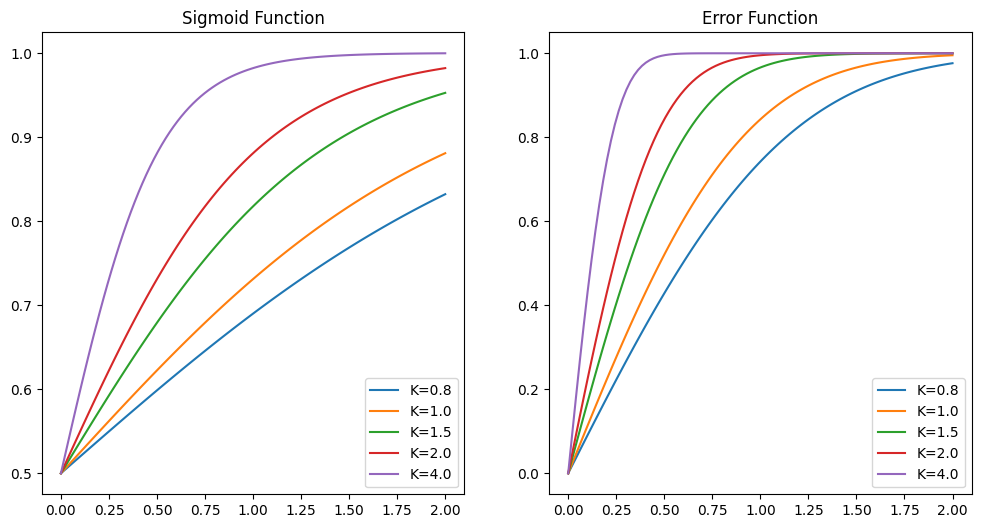

In [13]:
# Define the sigmoid function
def sigmoid(x, lam):
    return 1 / (1 + np.exp(-lam*x))

# Generate x values from 0 to 2
x = np.linspace(0, 2, 100)

# Compute the sigmoid function values
sigmoid_values1 = sigmoid(x, lam=0.8)
sigmoid_values2 = sigmoid(x, lam=1)
sigmoid_values3 = sigmoid(x, lam=1.5)
sigmoid_values4 = sigmoid(x, lam=2)
sigmoid_values5 = sigmoid(x, lam=4)


# Compute the error function values
def erf1(x, lam):
    return erf(lam*x)

erf_values1 = erf1(x, lam=0.8)
erf_values2 = erf1(x, lam=1)
erf_values3 = erf1(x, lam=1.5)
erf_values4 = erf1(x, lam=2)
erf_values5 = erf1(x, lam=4)

# Create a figure with 2 by 1 panels
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# plot the left panel
axs[0].plot(x, sigmoid_values1, label='K=0.8')
axs[0].plot(x, sigmoid_values2, label='K=1.0')
axs[0].plot(x, sigmoid_values3, label='K=1.5')
axs[0].plot(x, sigmoid_values4, label='K=2.0')
axs[0].plot(x, sigmoid_values5, label='K=4.0')
axs[0].set_title('Sigmoid Function')
axs[0].legend(loc = 'lower right')
#axs[0].legend()

# plot the right panel
axs[1].plot(x, erf_values1, label='K=0.8')
axs[1].plot(x, erf_values2, label='K=1.0')
axs[1].plot(x, erf_values3, label='K=1.5')
axs[1].plot(x, erf_values4, label='K=2.0')
axs[1].plot(x, erf_values5, label='K=4.0')
axs[1].set_title('Error Function')
axs[1].legend(loc = 'lower right')
#axs[1].legend()

# Plot the left panel with the sigmoid function
# axs[0].plot(x, sigmoid_values, label='Sigmoid')
# axs[0].set_title('Sigmoid Function')
# axs[0].legend(loc = 'lower right')

# # Plot the right panel with the error function
# axs[1].plot(x, erf_values, label='Error Function')
# axs[1].set_title('Error Function')
# axs[1].legend(loc = 'lower right')
plt.show()
# Set y limit from 0 to 1 for both panels
for ax in axs:
    ax.set_ylim(0, 1)

plt.show()

In [18]:
# # simulate x from 0 to 2 
# x = np.linspace(0, 2, 100)
# y1 = 1/(1 + (x/1)**(-0.5))
# y2 = 1/(1 + (x/0.5)**(-0.5))
# y3 = 1/(1 + (x/2)**(-0.5))
# plt.figure(figsize=(12, 6))
# plt.plot(x, y1, label='K=1')
# plt.plot(x, y2, label='K=0.5')
# plt.plot(x, y3, label='K=2')
# plt.legend()
# plt.show()

In [19]:
# Example value
x = 2

# Compute the error function
erf_value = erf(x)
print(f'The error function value at {x} is {erf_value}')

The error function value at 2 is 0.9953222650189527


In [20]:
# Weibull CDF 
def weibull_cdf(x, lam, k):
    return 1 - np.exp(-(x/lam)**k)

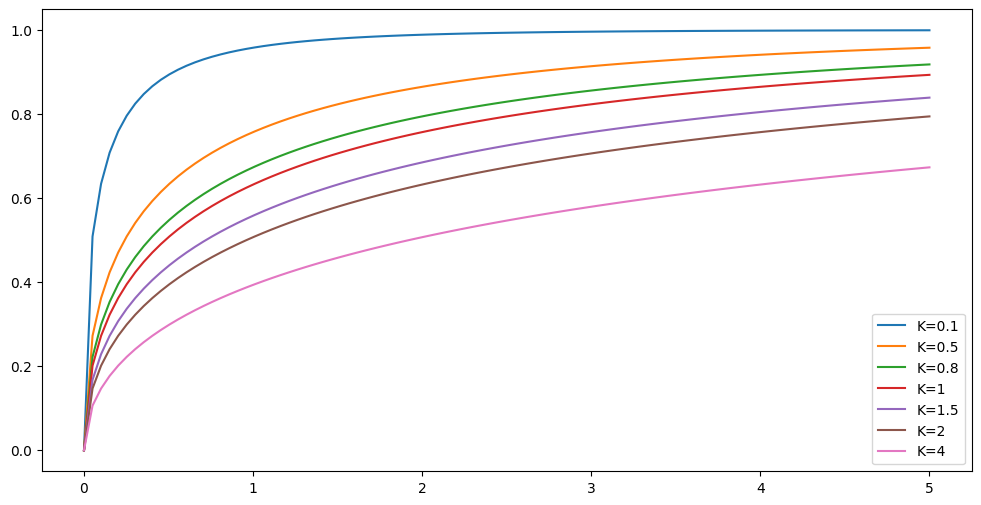

In [21]:
x = np.linspace(0, 5, 100)
K = 0.5
y1 = weibull_cdf(x, lam = 0.1, k = K)
y2 = weibull_cdf(x, lam = 0.5, k = K)
y3 = weibull_cdf(x, lam = 0.8, k = K)
y4 = weibull_cdf(x, lam = 1, k = K)
y5 = weibull_cdf(x, lam = 1.5, k = K)
y6 = weibull_cdf(x, lam = 2, k = K)
y7 = weibull_cdf(x, lam = 4, k = K)
plt.figure(figsize=(12, 6))
plt.plot(x, y1, label='K=0.1')
plt.plot(x, y2, label='K=0.5')
plt.plot(x, y3, label='K=0.8')
plt.plot(x, y4, label='K=1')
plt.plot(x, y5, label='K=1.5')
plt.plot(x, y6, label='K=2')
plt.plot(x, y7, label='K=4')
plt.legend()
plt.show()

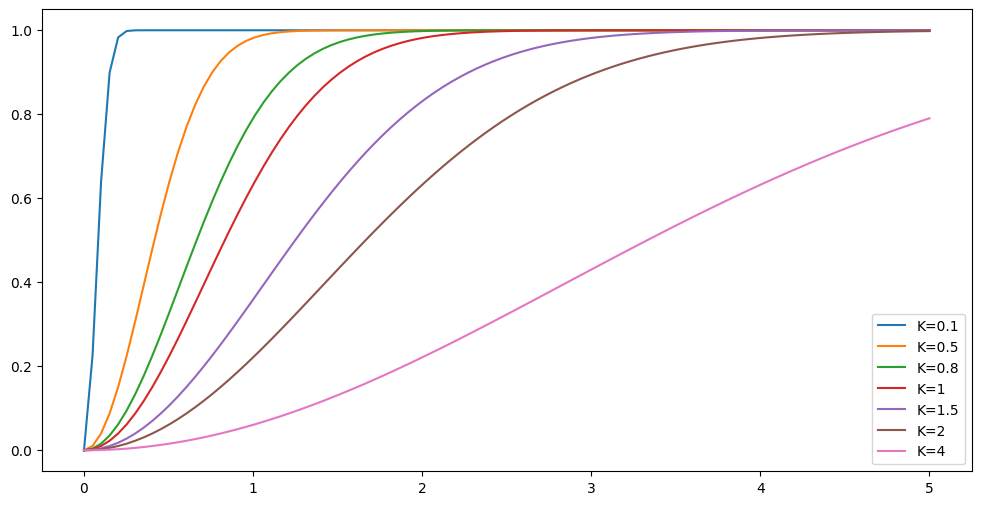

In [22]:
x = np.linspace(0, 5, 100)
K = 2
y1 = weibull_cdf(x, lam = 0.1, k = K)
y2 = weibull_cdf(x, lam = 0.5, k = K)
y3 = weibull_cdf(x, lam = 0.8, k = K)
y4 = weibull_cdf(x, lam = 1, k = K)
y5 = weibull_cdf(x, lam = 1.5, k = K)
y6 = weibull_cdf(x, lam = 2, k = K)
y7 = weibull_cdf(x, lam = 4, k = K)
plt.figure(figsize=(12, 6))
plt.plot(x, y1, label='K=0.1')
plt.plot(x, y2, label='K=0.5')
plt.plot(x, y3, label='K=0.8')
plt.plot(x, y4, label='K=1')
plt.plot(x, y5, label='K=1.5')
plt.plot(x, y6, label='K=2')
plt.plot(x, y7, label='K=4')
plt.legend()
plt.show()